# W207 Final Project
Erika, Jen Jen, Geoff, Leslie

(In Python 3)

As of 3/35

Outline:

* Data Pre-Processing  
* Simple Feature Selection
* Basline Models
* Possible Approaches
   

# 1. Libraries

In [3]:
# Import Libraries #
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# General libraries
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix



/home/levi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# 2. Standard Data

## 2.1 Raw Data 

In [4]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data

# pull in the training and test data
#with open('/Users/Jen2/Desktop/W207/project/train.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
#with open('/Users/Jen2/Desktop/W207/project/test.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
#print("\nSize of the normalized Data:", allTData.shape)
#print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)


## 2.2 Parsing Data

In [5]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
#print(list(flatData))
#print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    


In [6]:
# combine all text sources into a single corpus
fldTText = allTData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]
fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

trainCorpus = []
for index in range(len(subredTData)):
    a = ' '.join(subredTData['requester_subreddits_at_request'][index])
    b = (a, fldTText['request_text'][index], fldTText['request_text_edit_aware'][index],
        fldTText['request_title'][index])
    trainCorpus.append(' '.join(b))

devCorpus = []
for index in range(len(subredDData)):
    a = ' '.join(subredDData['requester_subreddits_at_request'][index])
    b = (a, fldDText['request_text'][index], fldDText['request_text_edit_aware'][index],
         fldDText['request_title'][index])
    devCorpus.append(' '.join(b))

# Print 3 examples  
#print (trainCorpus[:3])
labels = trainLabel.astype(int)
labels = list(labels)
#print(labels[:3])
#print('-'*75)

#print ('\n' , devCorpus[:3])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
#print(labels_dev[:3])

**TEXT : trainCorpus and devCorpus **

## 2.3 Simple Feature Selection and Pre-Processing

In [11]:
# Simple Pre-Processing

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=5
    num = 5
    def set_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    s = set_word(s)
    
    return s



In [9]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)
            temp.append(z)       
        return temp
    
    s = set_word(s)
    
    return s



SyntaxError: invalid syntax (<ipython-input-9-0d93020674cd>, line 23)

In [12]:
# Set up the data with CountVectorizer

#vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode',stop_words='english')

vectorizer = CountVectorizer(min_df=1,lowercase=True)
tVector = vectorizer.fit_transform(trainCorpus)
dVector = vectorizer.transform(devCorpus)

print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")

tVector_p = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer.transform(data_preprocessor(devCorpus))

print ('\nPre-Processed data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")


Raw data:
The size of the vocabulary for the training text data is 17213
First 5 feature Names: ['000', '0000', '0011011001111000', '00243364', '00pm'] 


Pre-Processed data:
The size of the vocabulary for the training text data is 10491
First 5 feature Names: ['aaaaa', 'aan', 'ab', 'aback', 'aband'] 



## 2.3 Add other features - votes, flair, time, user status, etc


* Add these features at a column on trainCorpus and devCorpus - later to test data

# Section 3. Baseline Models

## 3.1 Subreddit Models

## Logistic Regression

In [49]:
pca = PCA(n_components=4)
dVector_s = pca.fit(dVector)

pca.fit(dVector)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

  (0, 545)	2
  (0, 830)	4
  (0, 871)	2
  (0, 965)	4
  (0, 1032)	2
  (0, 1140)	2
  (0, 1185)	2
  (0, 1280)	2
  (0, 1742)	2
  (0, 2064)	2
  (0, 2632)	2
  (0, 3000)	2
  (0, 3302)	1
  (0, 3346)	2
  (0, 5502)	4
  (0, 5594)	2
  (0, 5732)	2
  (0, 5909)	2
  (0, 5937)	2
  (0, 6507)	2
  (0, 6736)	2
  (0, 6994)	2
  (0, 7030)	2
  (0, 7047)	2
  (0, 7097)	2
  :	:
  (999, 10394)	2
  (999, 10432)	2
  (999, 10580)	2
  (999, 11027)	2
  (999, 11054)	2
  (999, 11157)	2
  (999, 11192)	2
  (999, 11392)	2
  (999, 12370)	2
  (999, 12718)	1
  (999, 12877)	2
  (999, 13798)	2
  (999, 13822)	2
  (999, 13830)	2
  (999, 14658)	2
  (999, 15221)	4
  (999, 15347)	2
  (999, 15484)	17
  (999, 15914)	2
  (999, 16045)	2
  (999, 16140)	2
  (999, 16289)	2
  (999, 16639)	2
  (999, 16918)	2
  (999, 16952)	2


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [75]:
def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    


# Logistic Regressions

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.736
Area under curve of ROC:  0.528482328482
Classification report:

             precision    recall  f1-score   support

      False       0.75      0.96      0.84       740
       True       0.46      0.10      0.16       260

avg / total       0.68      0.74      0.67      1000

---------------------------------------------------------------------------


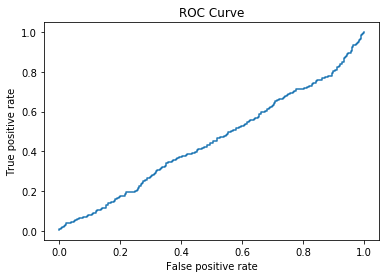

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.73
Area under curve of ROC:  0.524428274428
Classification report:

             precision    recall  f1-score   support

      False       0.75      0.95      0.84       740
       True       0.42      0.10      0.16       260

avg / total       0.66      0.73      0.66      1000

---------------------------------------------------------------------------


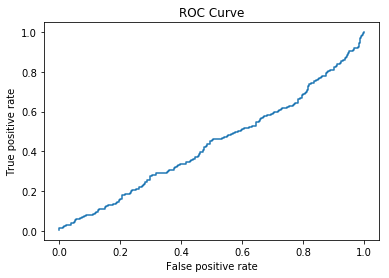

In [77]:
# Logistic Regression

C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector)[:,0])


modelLogit.fit(tVector_p,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector_p)[:,0])




## Naive Bayes

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.719
Area under curve of ROC:  0.556912681913
Classification report:

             precision    recall  f1-score   support

      False       0.77      0.89      0.82       740
       True       0.42      0.22      0.29       260

avg / total       0.68      0.72      0.69      1000

---------------------------------------------------------------------------


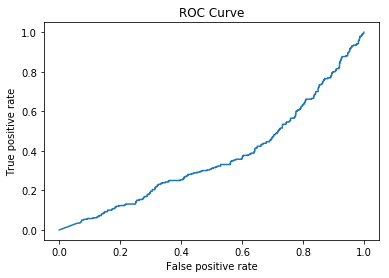

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.708
Area under curve of ROC:  0.560706860707
Classification report:

             precision    recall  f1-score   support

      False       0.77      0.87      0.81       740
       True       0.40      0.25      0.31       260

avg / total       0.67      0.71      0.68      1000

---------------------------------------------------------------------------


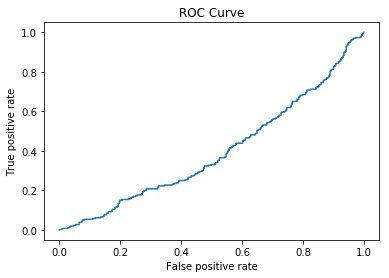

In [79]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)

clf.fit(tVector, trainLabel)
score_rep(devLabel, clf.predict(dVector),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector)[:,0])


clf.fit(tVector_p, trainLabel)
score_rep(devLabel,clf.predict(dVector_p),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector_p)[:,0])


## Logistic Regression More Feature Selection

In [20]:
# get the best regularization
regStrength = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 6.0, 10.0]


for c in regStrength:
    modelLogit = LogisticRegression(penalty='l1', C=c)
    modelLogit.fit(tVector_p, trainLabel)
    logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
    print("For C = ", c, "Logistic regression accuracy:", logitScore)

# although the best score comes from c=.001, the bet F1-score 
# comes from c=.5, and this gives better weight options
modelLogit = LogisticRegression(penalty='l1', C=.5, tol = .1)
modelLogit.fit(tVector_p, trainLabel)

print(max(modelLogit.coef_[0]))
numWeights = 5

sortIndex = np.argsort(modelLogit.coef_)
iLen = len(sortIndex[0])
print("\nTop", numWeights, "Weighted Features:")

for index in range((iLen - numWeights) , iLen):
    lookup = sortIndex[0][index]
    print(lookup)
    weight =  modelLogit.coef_[0][lookup]
    print(vectorizer.get_feature_names()[sortIndex[0][index]], weight)

For C =  0.0001 Logistic regression accuracy: 0.74
For C =  0.001 Logistic regression accuracy: 0.74
For C =  0.01 Logistic regression accuracy: 0.74
For C =  0.1 Logistic regression accuracy: 0.734
For C =  0.5 Logistic regression accuracy: 0.673
For C =  1.0 Logistic regression accuracy: 0.654
For C =  2.0 Logistic regression accuracy: 0.653
For C =  6.0 Logistic regression accuracy: 0.645
For C =  10.0 Logistic regression accuracy: 0.645
1.13322739957

Top 5 Weighted Features:
952
blah 0.732193980748
8010
scamm 0.736656575389
6543
orang 0.805602739749
10175
wiiu 0.864940001076
4292
hurti 1.13322739957


## User Status models

In [21]:
# LOGISTIC REGRESSION MODELS
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

# create training labels for pizza success
train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# Trial 1: Request / Retrieval 
diff_alone = np.asarray(statusTtrain[['Request', 'Retrieval']].copy())
diff_dev_alone = np.asarray(statusDtrain[['Request', 'Retrieval']].copy())
train_model = lr.fit(diff_alone, train_labels)
dev_alone_labels = train_model.predict(diff_dev_alone)
alone_score = train_model.score(diff_dev_alone, dev_labels)
alone_F1score = metrics.f1_score(dev_alone_labels, dev_labels)
print("For model with Request/Retrieval/Request-Retrieval Difference only")
print("Accuracy:", alone_score)
print("F1 score:", alone_F1score)

# Trial 2:  Z-scores for Request / Retrieval 
zdiff_train = statusTtrain[['Request Z-score','Retrieval Z-score']]
zdiff_dev = statusDtrain[['Request Z-score','Retrieval Z-score']]
zdiff_model = lr.fit(zdiff_train, train_labels)
zdiff_labels = zdiff_model.predict(zdiff_dev)
zdiff_score = zdiff_model.score(zdiff_dev, dev_labels)
zdiff_F1score = metrics.f1_score(zdiff_labels, dev_labels)
print("\nFor model with Request / Retrieval Z-scores only :")
print("Accuracy:", zdiff_score)
print("F1 score:", zdiff_F1score)

# Trial 3:  Z-scores for Request-Retrieval 
# Create Z-scores request-retrieval
diff_combined = np.asarray(statusTtrain[['Request-Retrieval Z-score']].copy())
diff_dev_combined = np.asarray(statusDtrain[['Request-Retrieval Z-score']].copy())
train_combine_model = lr.fit(diff_combined, train_labels)
dev_combine_labels = train_combine_model.predict(diff_dev_combined)
combine_score = train_combine_model.score(diff_dev_combined, dev_labels)
combine_F1score = metrics.f1_score(dev_combine_labels, dev_labels)
print("\nFor model with Request-Retrieval Z-Score only")
print("Accuracy:", combine_score)
print("F1 score:", combine_F1score)

# Trial 4:  Z-scores for Request / Retrieval / Diff / Flair
zcomb_train = statusTtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_train.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_dev = statusDtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_dev.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_model = lr.fit(zcomb_train, train_labels)
zcomb_labels = zcomb_model.predict(zcomb_dev)
zcomb_score = zcomb_model.score(zcomb_dev, dev_labels)
zcomb_F1score = metrics.f1_score(zcomb_labels, dev_labels)
print("\nZ-scores for Request / Retrieval:")
print("Accuracy:", zcomb_score)
print("F1 score:", zcomb_F1score)

For model with Request/Retrieval/Request-Retrieval Difference only
Accuracy: 0.737
F1 score: 0.0

For model with Request / Retrieval Z-scores only :
Accuracy: 0.737
F1 score: 0.0

For model with Request-Retrieval Z-Score only
Accuracy: 0.738
F1 score: 0.0


ValueError: could not convert string to float: 'shroom'

# Future Steps

* More data pre-processing (looking for newer features too)
* Explore PCA/LSA
* Ideas on features
    - Combination of words
    - Pruning
    - Timing (of requests)
    - Location
    

In [52]:

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 28.130s.
Extracting tf-idf features for NMF...
done in 0.389s.
Extracting tf features for LDA...
done in 0.344s.
Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.200s.

Topics in NMF model:
Topic #0:
just people don think like know time good make way really say right ve want did ll new use years
Topic #1:
windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2:
god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3:
thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4:
car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5:
edu soon com send university internet mit ftp mail cc pub article information hop